In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.neighbors import NearestNeighbors

mpl.rcParams['pdf.fonttype'] = 42

In [2]:
h5_file = 'vdj_v1_hs_pbmc2_5gex_protein_filtered_feature_bc_matrix.h5'
CD45_output = 'isoform_probabilities.csv' # Output of CD45er

## Load and pre-process data

In [3]:
pbmc = sc.read_10x_h5(h5_file, gex_only=False)
pbmc.var_names_make_unique()
pbmc.layers["counts"] = pbmc.X.copy()
sc.pp.filter_genes(pbmc, min_counts=1)

protein = pbmc[:, pbmc.var["feature_types"] == "Antibody Capture"].copy()
protein.layers["counts"] = protein.X.copy()
sc.pp.normalize_total(protein,target_sum=1e4)
sc.pp.log1p(protein)


rna = pbmc[:, pbmc.var["feature_types"] == "Gene Expression"].copy()

/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


## RNA Filtering

### Mitochondrial fractions

In [4]:
rna.var["mito"] = rna.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(rna, qc_vars=["mito"], inplace=True)


Text(0, 0.5, '# Cells')

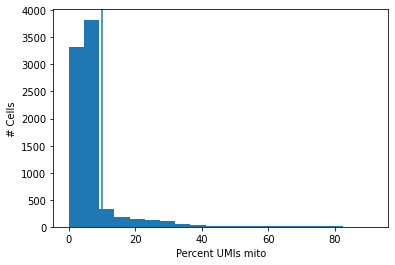

In [5]:
mt_thresh = 10

plt.hist(rna.obs['pct_counts_mito'],20);
plt.axvline(mt_thresh)
plt.xlabel('Percent UMIs mito')
plt.ylabel('# Cells')

In [6]:
# Do the filtering
rna = rna[rna.obs['pct_counts_mito']<mt_thresh]


### Doublet filtering

In [7]:
sc.external.pp.scrublet(rna)

/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


Automatically set threshold at doublet score = 0.21
Detected doublet rate = 4.0%
Estimated detectable doublet fraction = 58.0%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 6.8%


/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/scanpy/external/pp/_scrublet.py:227: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['doublet_score'] = adata_obs.obs['doublet_score']


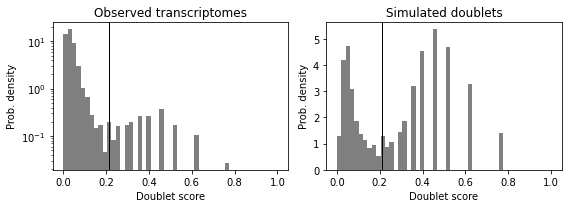

In [8]:
sc.external.pl.scrublet_score_distribution(rna)

In [9]:
rna = rna[~rna.obs['predicted_doublet'],:]

## T-cell isolation
For simiplicity, we'll just restrict to CD3+ cells by the protein data to isolate T-cells

/tmp/ipykernel_3701/1299648152.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna.obs[protein.var.index] = protein.to_df()


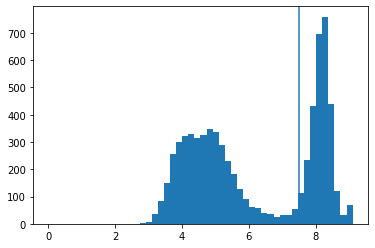

In [10]:
CD3_thresh = 7.5
rna.obs[protein.var.index] = protein.to_df()
plt.hist(rna.obs['CD3_TotalSeqC'],50);
plt.axvline(CD3_thresh)

In [11]:
rna = rna[rna.obs['CD3_TotalSeqC']>CD3_thresh,:]

#### RNA-preprocessing

In [12]:
rna.layers["counts"] = rna.X.copy()

rna.obs['total_counts'] = \
    np.array(rna[:,rna.var['feature_types']=='Gene Expression'].X.sum(axis=1)).reshape(-1)

sc.pp.normalize_total(rna,target_sum=1e4)
sc.pp.log1p(rna)

rna.raw = rna

sc.pp.pca(rna)
sc.pp.neighbors(rna, n_neighbors=30)
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added="rna_leiden")

sc.tl.umap(rna)


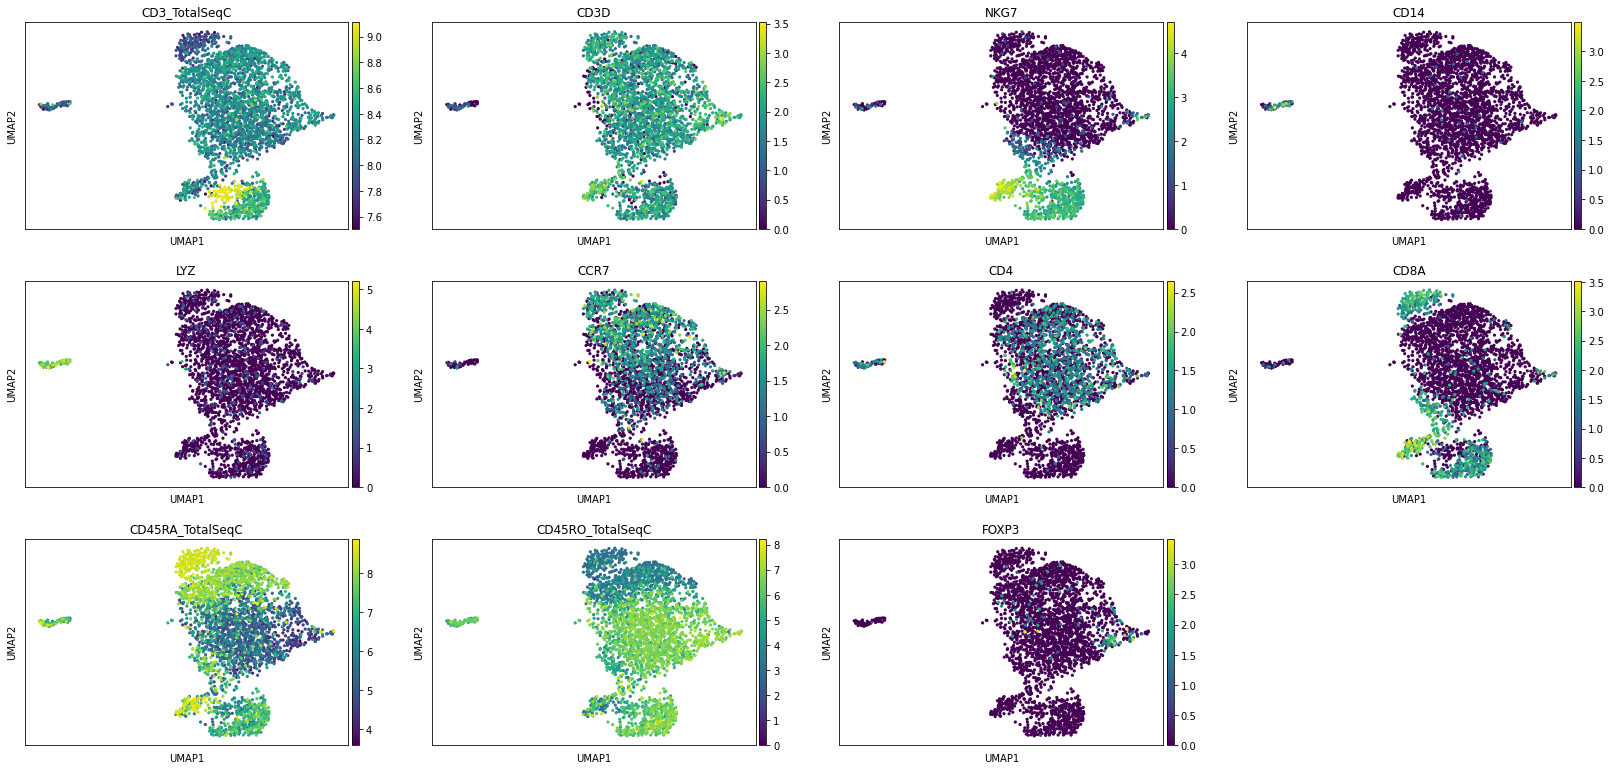

In [13]:
sc.pl.umap(rna,color=['CD3_TotalSeqC','CD3D','NKG7','CD14',
                      'LYZ','CCR7','CD4','CD8A','CD45RA_TotalSeqC','CD45RO_TotalSeqC','FOXP3'])

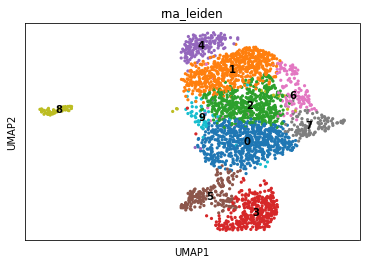

In [14]:
sc.pl.umap(rna,color='rna_leiden',legend_loc = 'on data')

In [15]:
# A small population of monocytes survived the CD3 selection, filter these and re-cluster
rna = rna[rna.obs['rna_leiden']!='8']

sc.pp.neighbors(rna)
sc.tl.umap(rna)
sc.tl.leiden(rna, key_added="rna_leiden")

sc.tl.umap(rna)

## Annotate CD45 isoform measurements

In [16]:
# Annotate CD45 isoform estimates
C = pd.read_csv(CD45_output)
C['CD45RO'] = C['RX']
C['CD45RA'] = C['RAX']+C['RABX']+C['RABCX']
C['CD45RB'] = C['RBX']
C['CD45RAX'] = C['RAX']
C['CD45RABX'] = C['RABX']
C['CD45RABCX'] = C['RABCX']    
    



for iso in ['RO','RA','RB','RAX','RABX','RABCX']:
    rna.obs['CD45' + iso + '_counts'] = C.groupby('CB')['CD45' + iso].sum()
    rna.obs.loc[rna.obs['CD45'+iso+'_counts'].isna(),'CD45'+iso+'_counts'] = 0
    rna.obs['CD45'+iso] = np.log(1+1e4*rna.obs['CD45'+iso+'_counts']/rna.obs['total_counts'])

## Perform knn-smoothing of marker genes

In [17]:
k=20
npc=15

markers = ['CD4','CD8A','CD45RO','CD45RA','CCR7']
    
nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(rna.obsm['X_pca'][:,0:npc])
distances, indices = nbrs.kneighbors(rna.obsm['X_pca'][:,0:npc])

    
    
for gene in markers:
        if gene in ['CD45RO','CD45RA','CD45RB']:
            rna.obs['knn'+gene] = rna.obs[gene].values[indices.reshape(-1)].reshape(-1,k).mean(axis=1)
        else:
            rna.obs['knn'+gene] = np.array(rna.raw[:,gene].X[indices.reshape(-1)].\
                                             reshape(-1,k).mean(axis=1)).reshape(-1)

## Visualize RNA vs protein measurements on U-MAPs

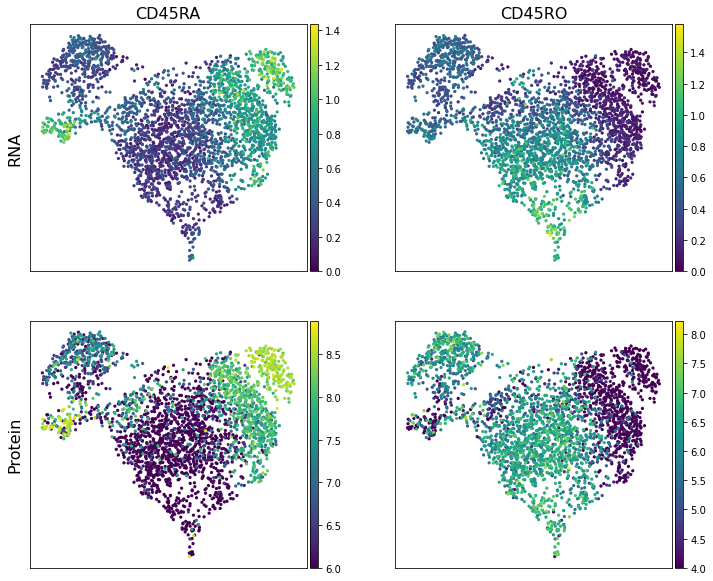

In [18]:
genes = ['knnCD45RA','knnCD45RO','CD45RA_TotalSeqC','CD45RO_TotalSeqC']

f,ax = plt.subplots(2,2,figsize=(12,10))
ax = ax.reshape(-1)

vmins = [0,0,6,4]

ylabels = ['RNA','','Protein','']
titles = ['CD45RA','CD45RO','','']


i=0
for gene in genes:
    sc.pl.umap(rna,color=gene,
          ax=ax[i],show=False,
               vmin=vmins[i])
    
    ax[i].set_ylabel(ylabels[i],fontsize=16)
    ax[i].set_title(titles[i],fontsize=16)
    ax[i].set_xlabel('')
    i+=1
    


## Scatterplot values

Text(0.5, 0, 'CD45RO (RNA)')

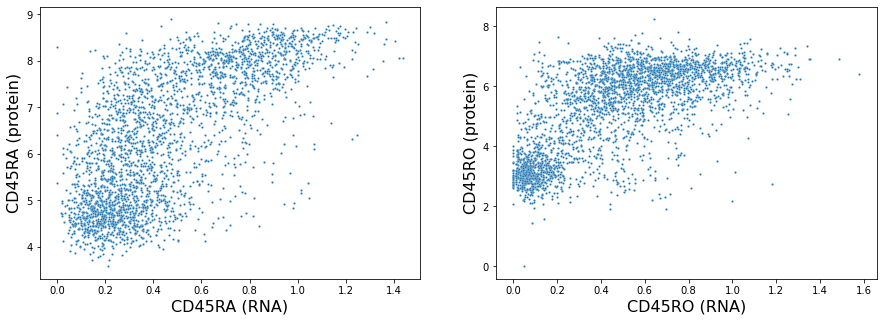

In [19]:
f,ax = plt.subplots(1,2,figsize=(15,5))
isoforms = ['CD45RA','CD45RO']

for i in range(0,2):
    sns.scatterplot(x=f"knn{isoforms[i]}",y=f"{isoforms[i]}_TotalSeqC",data=rna.obs,s=5,ax=ax[i])
    
ax[0].set_ylabel('CD45RA (protein)',fontsize=16)
ax[1].set_ylabel('CD45RO (protein)',fontsize=16)
ax[0].set_xlabel('CD45RA (RNA)',fontsize=16)
ax[1].set_xlabel('CD45RO (RNA)',fontsize=16)

## Visualize subset distributions with flow-style plots

In [20]:
def flow_plot(adata,xplot,yplot,
                    xcutoff=None,ycutoff=None,label_quadrants=False,
                   ax=None):
    
        if ax is None:
            f,ax = plt.subplots(1)


        sns.kdeplot(adata.obs[xplot],adata.obs[yplot],ax=ax)
    
        if not xcutoff is None:
            ax.axvline(xcutoff,color='k')
        if not ycutoff is None:
            ax.axhline(ycutoff,color='k')
        
        if label_quadrants:
            pos_x = pd.Categorical(adata.obs[xplot]>xcutoff,categories=[False,True])
            pos_y = pd.Categorical(adata.obs[yplot]>ycutoff,categories=[False,True])
            
            pos_count = pd.crosstab(pos_x,pos_y, dropna=False)
            
            
            
            pos_frac = pos_count/pos_count.sum().sum()
            
            xl = ax.get_xlim()
            xr = xl[1]-xl[0]
            yl=ax.get_ylim()
            yr=yl[1]-yl[0]
            
            
            xshift = {False:xl[0]+xr*.05,True:xl[0]+.8*xr} if not xcutoff is None else {False:xl[0]+.8*xr}
            yshift = {False:yl[0]+yr*.05,True:yl[0]+.9*yr} if not ycutoff is None else {False:yl[0]+.9*yr}
            
            xlab_show = [False,True] if not xcutoff is None else [False]
            ylab_show = [False,True] if not ycutoff is None else [False]
            
            for is_x_pos in xlab_show:
                for is_y_pos in ylab_show:
                    ax.text(xshift[is_x_pos],
                             yshift[is_y_pos],
                             f"{100*pos_frac.loc[is_x_pos,is_y_pos]:.1f}%")
                


/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/njharlen/anaconda3/envs/scanpy1_8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an e

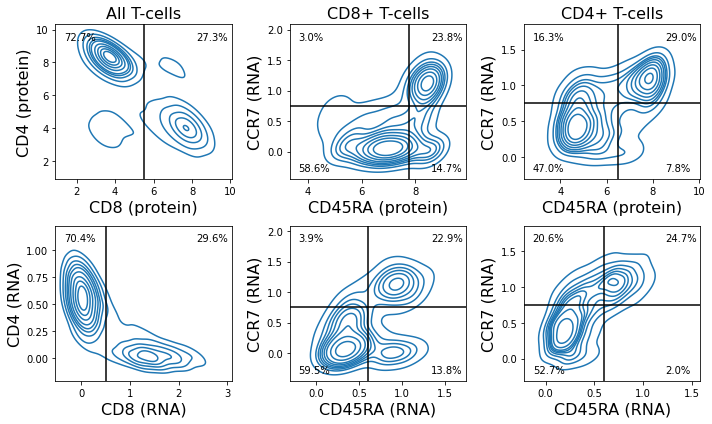

In [21]:
## Flow plots

f,ax = plt.subplots(2,3,figsize=(10,6))


# CD4/8 plots
flow_plot(rna,'CD8a_TotalSeqC','CD4_TotalSeqC',xcutoff=5.5,label_quadrants=True,ax=ax[0,0])
flow_plot(rna,'knnCD8A','knnCD4',xcutoff=.5,label_quadrants=True,ax=ax[1,0])
ax[0,0].set_xlabel('CD8 (protein)',fontsize=16)
ax[0,0].set_ylabel('CD4 (protein)',fontsize=16)
ax[1,0].set_xlabel('CD8 (RNA)',fontsize=16)
ax[1,0].set_ylabel('CD4 (RNA)',fontsize=16)

# Classify CD4/8
cd8_protein = rna.obs['CD8a_TotalSeqC']>5.5
cd8_rna = rna.obs['knnCD8A']>.5


flow_plot(rna[cd8_protein],'CD45RA_TotalSeqC','knnCCR7',xcutoff=7.75,
          ycutoff=.75,label_quadrants=True,ax=ax[0,1])
ax[0,1].set_xlabel('CD45RA (protein)',fontsize=16)
ax[0,1].set_ylabel('CCR7 (RNA)',fontsize=16)

flow_plot(rna[~cd8_protein],'CD45RA_TotalSeqC','knnCCR7',xcutoff=6.5,
          ycutoff=.75,label_quadrants=True,ax=ax[0,2])
ax[0,2].set_xlabel('CD45RA (protein)',fontsize=16)
ax[0,2].set_ylabel('CCR7 (RNA)',fontsize=16)


cd45ra_protein = (rna.obs['CD45RA_TotalSeqC']>7.75)|((rna.obs['CD45RA_TotalSeqC']>6.5)&~cd8_protein)


flow_plot(rna[cd8_protein],'knnCD45RA','knnCCR7',xcutoff=.6,
          ycutoff=.75,label_quadrants=True,ax=ax[1,1])
ax[1,1].set_xlabel('CD45RA (RNA)',fontsize=16)
ax[1,1].set_ylabel('CCR7 (RNA)',fontsize=16)


flow_plot(rna[~cd8_protein],'knnCD45RA','knnCCR7',xcutoff=.6,
          ycutoff=.75,label_quadrants=True,ax=ax[1,2])
ax[1,2].set_xlabel('CD45RA (RNA)',fontsize=16)
ax[1,2].set_ylabel('CCR7 (RNA)',fontsize=16)

ax[0,0].set_title('All T-cells',fontsize=16)
ax[0,1].set_title('CD8+ T-cells',fontsize=16)
ax[0,2].set_title('CD4+ T-cells',fontsize=16)




cd45ra_rna = rna.obs['knnCD45RA']>1.5
ccr7_rna = rna.obs['knnCCR7']>.75

plt.tight_layout()